In [1]:
import os
import torch
import soundfile as sf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import numpy as np
import IPython
from tqdm import tqdm
import pickle
# 数据生成
from scipy import stats
from fitter import Fitter

from Process_Data.audio_processing import read_WaveInt
from Define_Model.model import create_model, load_model_args, create_classifier
from Define_Model.SoftmaxLoss import AdditiveMarginLinear

In [2]:
from Process_Data.Datasets.SelectDataset import cost_func
from geomloss import SamplesLoss

In [3]:
import torch.nn.functional as F

In [4]:
lstm_path = '/home/yangwenhao/project/lstm_speaker_verification'
root_path='/home/yangwenhao/project/SpeakerVerification-pytorch'

In [3]:
model_dir = 'ECAPA_brain/Mean_batch48_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_mix/'
train_set = 'vox1'
check_path = root_path +  '/Data/checkpoint/' + model_dir + '/{}'.format(1234)
check_yaml = model_dir + '/model.yaml'

In [77]:
# baseline chn384
model_dir = 'ECAPA_brain/Mean_batch48_SASP2_em192_chn384_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_mix'
train_set = 'vox1'
check_path = root_path +  '/Data/checkpoint/' + model_dir + '/{}'.format(1234)
check_yaml = root_path +  '/Data/checkpoint/' + model_dir + '/model.yaml'

In [84]:
# baseline chn384 inbn no_affine

model_dir = 'ECAPA_brain/Mean_batch48_inbn_SASP2_em192_chn384_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_mix'
train_set = 'vox1'
check_path = root_path +  '/Data/checkpoint/' + model_dir + '/{}'.format(1234)
check_yaml = root_path +  '/Data/checkpoint/' + model_dir + '/model.yaml'

In [5]:
# baseline chn256 clean
model_dir = 'ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53'
train_set = 'vox1'
check_path = root_path +  '/Data/checkpoint/' + model_dir + '/{}'.format(1234)
check_yaml = root_path +  '/Data/checkpoint/' + model_dir + '/model.yaml'

In [58]:
# baseline chn256 clean+mix
model_dir = 'ECAPA_brain/Mean_batch48_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_mix'
train_set = 'vox1'
check_path = root_path +  '/Data/checkpoint/' + model_dir + '/{}'.format(1234)
check_yaml = root_path + '/Data/checkpoint/' + model_dir  + '/model.yaml'

In [134]:
# baseline chn256 inbn affine clean
model_dir = 'ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_inst05'
train_set = 'vox1'
check_path = root_path +  '/Data/checkpoint/' + model_dir + '/{}'.format(1234)
check_yaml = root_path +  '/Data/checkpoint/' + model_dir + '/model.yaml'

In [156]:
# baseline chn256 inbn affine clean wave_fb80_inst_aug53_inbnx1
model_dir = 'ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_inbnx1'
train_set = 'vox1'
check_path = root_path +  '/Data/checkpoint/' + model_dir + '/{}'.format(1234)
check_yaml = root_path +  '/Data/checkpoint/' + model_dir + '/model.yaml'

In [6]:
model_kwargs = load_model_args(check_yaml)
model = model_kwargs['embedding_model']
if 'classifier' in model_kwargs:
    model.classifier = model_kwargs['classifier']

create_classifier(model, **model_kwargs)

In [85]:
check_yaml

'/home/yangwenhao/project/SpeakerVerification-pytorch/Data/checkpoint/ECAPA_brain/Mean_batch48_inbn_SASP2_em192_chn384_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53_mix/model.yaml'

In [7]:
resume_path = check_path + '/checkpoint_{}.pth'
# ep = 24 # Load model from Checkpoint file
ep = 'avg3' # Load model from Checkpoint file

if os.path.isfile(resume_path.format(ep)):
    checkpoint = torch.load(resume_path.format(ep))
    checkpoint_state_dict = checkpoint['state_dict']
    if isinstance(checkpoint_state_dict, tuple):
        checkpoint_state_dict = checkpoint_state_dict[0]

    filtered = {k: v for k, v in checkpoint_state_dict.items() if 'num_batches_tracked' not in k}
    if list(filtered.keys())[0].startswith('module'):
        new_state_dict = OrderedDict()
        for k, v in filtered.items():
            name = k[7:]  # remove `module.`，表面从第7个key值字符取到最后一个字符，去掉module.
            new_state_dict[name] = v  # 新字典的key值对应的value为一一对应的值。
        model.load_state_dict(new_state_dict)
    else:
        model_dict = model.state_dict()
        model_dict.update(filtered)
        model.load_state_dict(model_dict)
        
model = model.eval()

In [51]:
torch.nn.init.ones_(model.asp_bn.norm.weight)
torch.nn.init.zeros_(model.asp_bn.norm.bias)

Parameter containing:
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:1', requires_grad=True)

In [57]:
model.asp_bn.norm.running_mean

torch.Size([2304])

#### Data loaders

In [23]:
total_utts = 2000

In [8]:
audio_uids = []
total_utts = 2000

np.random.seed(1234)
with open('/home/yangwenhao/project/lstm_speaker_verification/data/vox1/dev/wav.scp', 'r') as f:
    for l in tqdm(f.readlines(), ncols=50):
        if np.random.uniform(0,1) <= 0.2:
            uid, upath = l.split()
            wav, sr = sf.read(upath)
            dur = float(len(wav)/sr)

            if dur >= 6 :
                # uid[7] = '/'
                # uid[-6] = '/'
                uid_path = '/'.join(upath.split('/')[-3:])[:-4]
                # uid_path = uid.replace('-', '/')
                # id10270-5r0dWxy17C8-00010
                audio_uids.append(uid_path)

            if len(audio_uids) >= total_utts:
                break
            

 12%|▍   | 18189/148642 [00:10<01:16, 1695.03it/s]


In [67]:
len(set([s.split('/')[0] for s in audio_uids]))

148

In [9]:
audios = []

common_path = '/home/yangwenhao/dataset/voxceleb1/voxceleb1_wav/vox1_dev_wav'
duration = 32000

for uid in tqdm(audio_uids, ncols=50):
    # upath = '/home/yangwenhao/dataset/voxceleb1/voxceleb1_wav/vox1_test_wav/wav/{}.wav'.format(uid)
    # upath_radio_dist0 = '/home/yangwenhao/dataset/voxceleb1/voxceleb1_wav/vox1_test_wav/wav_radchn2/{}.wav'.format(uid)
    upath = '{}/wav/{}.wav'.format(common_path, uid)
    upath_radio = '{}/wav_nb_radsnr1/{}.wav'.format(common_path, uid)
    
    paths = [upath, upath_radio]
    paths.extend(['{}/{}/{}.wav'.format(common_path, s, uid) for s in \
                  ['wav_nb_randsnr0', 'wav_nb_radsnr05', 'wav_nb_randsnr2', 'wav_nb_randsnr5', ]])
    this_audio = [torch.tensor(read_WaveInt(paths[0],
                                  start=20000, stop=20000+duration)).reshape(1,1,-1)]
    for u in paths[1:]:
        this_audio.append(torch.tensor(read_WaveInt(u,
                                  start=16000, stop=16000+duration)).reshape(1,1,-1))

    audios.append(torch.cat(this_audio, dim=0))

 36%|███▌      | 722/2000 [00:30<00:53, 23.77it/s]

KeyboardInterrupt



In [90]:
with open('data/radio_clean.pickle', 'wb') as f:
    pickle.dump(audios, f)

In [10]:
with open('data/radio_clean.pickle', 'rb') as f:
    audios = pickle.load(f)

### feature mappings

In [11]:
idxs = np.arange(len(audios))
np.random.seed(1234)

np.random.shuffle(idxs)

In [13]:
torch.cuda.set_device(4)
device = 'cuda:4'

fms = []

model = model.cuda()
with torch.no_grad():
    # for x in tqdm(audios, ncols=50):
    for i in tqdm(idxs, ncols=50):
        x = audios[i]
        
        fb_x = model.input_mask(x.cuda())
        if len(fb_x.shape) == 4:
            fb_x = fb_x.squeeze(1).float()
        fb_x = fb_x.transpose(1, 2)

        x1 = model.blocks[0](fb_x)
        x2 = model.blocks[1](x1)
        x3 = model.blocks[2](x2)
        x4 = model.blocks[3](x3)
        
        # xs.append(torch.stack([x1, x2, x3, x4,]))
        x5 = torch.cat([x2, x3, x4], dim=1)
        x6 = model.mfa(x5)
        x7 = model.asp(x6, lengths=None)
        x8 = model.asp_bn(x7)
        
        embeddings = model.fc(x8)
        
        fms.append([x1.detach().cpu(), x2.detach().cpu(), x3.detach().cpu(),
                    x4.detach().cpu(), x5.detach().cpu(), x6.detach().cpu(),
                    x7.detach().cpu(), x8.detach().cpu(), embeddings.detach().cpu()])
        
# xs = torch.stack(xs)

100%|█████████| 2000/2000 [00:43<00:00, 46.23it/s]


In [ ]:
with open('imgs/mix_model_chn384/fms.pickle', 'wb') as f:
# with open('imgs/inst_model_chn384/fms.pickle', 'wb') as f:
    pickle.dump(fms, f)

#### distance function

In [134]:
akld_fn = lambda a,b: (torch.log((a.std(dim=0)+1e-6)/(b.std(dim=0)+1e-6)) + (a.var(dim=0) + (a.mean(dim=0)-b.mean(dim=0))**2)/(2*b.var(dim=0)+1e-6) - 0.5).mean()

#### asymmetric KLD from IBN-Net

In [141]:
def kld_fn(a, b):
    a = a.reshape(-1, a.shape[1])
    b = b.reshape(-1, b.shape[1])
    return (torch.log((a.std(dim=0)+1e-6)/(b.std(dim=0)+1e-6)) + (a.var(dim=0) + (a.mean(dim=0)-b.mean(dim=0))**2)/(2*b.var(dim=0)+1e-6) - 0.5).mean()

akld_fn = lambda a,b: kld_fn(a, b) + kld_fn(b, a)

In [96]:
kld(torch.randn(12,2,4), torch.randn(12,2,4)).mean()

tensor(0.1679)

#### KLD loss

In [62]:
kld_fn = torch.nn.KLDivLoss()
kld_dist_fn = lambda a,b: kld_fn(F.log_softmax(a, dim=1), F.softmax(b)) + kld_fn(F.log_softmax(b, dim=1), F.softmax(a))

In [98]:
akld_fn = lambda a,b: (torch.log(a.std(dim=0)/b.std(dim=0)) + a.var(dim=0) + (a.mean(dim=0)-b.mean(dim=0))**2/(2*b.var(dim=0)) - 0.5).mean()

#### Sinkhorn distance

In [14]:
sinkhorn_fn = SamplesLoss("sinkhorn", p=2, blur=0.05, cost=lambda a, b: cost_func(a, b, p=2, metric='cosine'))
# opt_dist_fn = lambda a,b: sinkhorn_fn(a.transpose(0,1), b.transpose(0,1))
opt_dist_fn = lambda a,b: sinkhorn_fn(a, b)

In [11]:
fms[0][0].shape

torch.Size([2, 256, 401])

In [14]:
loss_fn(fms[0][0][0], fms[0][0][1])

/home/yangwenhao/anaconda3/envs/py38_torch12/lib/python3.8/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


tensor(-0.1222)

In [15]:
dist = []
dist_base = []

dist_fn = opt_dist_fn
batch_size = 400
batch_shift  = batch_size//2
stats = True
# total_utts // batch_size

for i in tqdm(range(total_utts // batch_shift), ncols=50):
    start = i*batch_shift
    end = start + batch_size
    
    fm = fms[start:end]
    
    # if end + batch_size//2 <= total_utts:
    #     another_fm = fms[(end- batch_size//2):(end + batch_size//2)]
    if end + batch_size <= total_utts:
        another_fm = fms[end:(end + batch_size)]
    else:
        another_fm = fms[(start-batch_size):start]
    
    this_d = []
    this_bd = []
    
    for j in range(len(fm[0])):
        
        this_f = torch.stack([f[j] for f in fm], dim=0)
        f0 = this_f[:, 0].cuda()
        if len(f0.shape) >=3 and stats:
            f0 = torch.cat([f0.mean(dim=-1), f0.std(dim=-1)], dim=-1)
        
        this_f0 = torch.stack([f[j] for f in another_fm], dim=0)
        f00 = this_f0[:, 0].cuda()
        if len(f00.shape) >=3 and stats:
            f00 = torch.cat([f00.mean(dim=-1), f00.std(dim=-1)], dim=-1)
            
        idx = np.arange(len(f0))
        np.random.shuffle(idx)
        l = float(dist_fn(f0, f00[idx]).mean())
        this_bd.append(l)
        
        d = []
        for n in range(1, this_f.shape[1]):
            # f1 = this_f[:, n].cuda()
            f1 = this_f0[:, n].cuda()

            if len(f1.shape) >=3 and stats:
                f1 = torch.cat([f1.mean(dim=-1), f1.std(dim=-1)], dim=-1)

            l = float(dist_fn(f0, f1[idx]).mean())
            if np.isnan(l):
                print(i, j)

            d.append(l)
            
        this_d.append(d)
        
        # print(l, f0.shape, f1.shape)
    dist.append(this_d)
    dist_base.append(this_bd)
    # break
        
# for fm in tqdm(fms, ncols=50):
#     dist.append([float(loss_fn(F.log_softmax(f[0].cuda(), dim=-1), F.softmax(f[1].cuda(), dim=-1)) + \
#                        loss_fn(F.log_softmax(f[1].cuda(), dim=-1), F.softmax(f[0].cuda(), dim=-1))) for f in fm])

100%|█████████████| 10/10 [01:30<00:00,  9.07s/it]


In [ ]:
model

In [64]:
# with open('imgs/inst_model_chn384/dist.pickle', 'wb') as f:
# with open('imgs/model_chn256/dist.4.pickle', 'wb') as f:
# with open('imgs/model_chn256_inst/dist.4.pickle', 'wb') as f:
# with open('imgs/model_chn256_inst/dist.4.x1.pickle', 'wb') as f:
# with open('imgs/model_chn256_mix/dist.4.x1.pickle', 'wb') as f:
# with open('imgs/model_chn256/dist.4.x2.pickle', 'wb') as f:
with open('imgs/model_chn256_mix/dist.4.x2.pickle', 'wb') as f:
    pickle.dump([dist_base, dist], f)

In [117]:
this_f = torch.stack([f[4] for f in fm], dim=0)

f0 = this_f[:, 0].cuda()
f1 = this_f[:, 1].cuda()

In [118]:
dist_fn(f0, f1[idx])

tensor(nan, device='cuda:1')

In [130]:
a = f0
b = f1[idx]

print(torch.log(((a.std(dim=0)+1e-6)/(b.std(dim=0)+1e-6))).mean())
print(((a.var(dim=0) + (a.mean(dim=0)-b.mean(dim=0))**2)/(2*b.var(dim=0)+1e-6)).mean())

tensor(0.0786, device='cuda:1')
tensor(0.7334, device='cuda:1')


In [125]:
(a.std(dim=0)/b.std(dim=0)).min()

tensor(nan, device='cuda:1')

In [219]:
# import matplotlib
# matplotlib.matplotlib_fname()

import matplotlib

# matplotlib.font_manager.

In [212]:
print(matplotlib.get_cachedir())

/home/yangwenhao/.cache/matplotlib


In [6]:
import matplotlib as mpl

fpath = os.path.join(mpl.get_data_path(), "fonts/ttf/Arial.ttf")

In [11]:
plt.rcParams["font.serif"] #= "sans-serif"


['DejaVu Serif',
 'Bitstream Vera Serif',
 'Computer Modern Roman',
 'New Century Schoolbook',
 'Century Schoolbook L',
 'Utopia',
 'ITC Bookman',
 'Bookman',
 'Nimbus Roman No9 L',
 'Times New Roman',
 'Times',
 'Palatino',
 'Charter',
 'serif']

In [7]:
fpath

'/home/yangwenhao/anaconda3/envs/py38_torch12/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf'

In [24]:
from Define_Model.MixStyle import SinkhornDistance


In [53]:
def alignmix(feat_s, feat_t, lamda_beta=0.1):
    """
    feat_s: B, C, T
    
    feat_t: B, C, T
    
    """
    mix_size = feat_s.shape[0]
    
    feat1 = torch.cat([feat_s.mean(dim=2, keepdim=True), feat_s.std(dim=2, keepdim=True)], dim=2)
    feat2 = torch.cat([feat_t.mean(dim=2, keepdim=True), feat_t.std(dim=2, keepdim=True)], dim=2)

    sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction=None)
    P = sinkhorn(feat1.permute(0, 2, 1),
                 feat2.permute(0, 2, 1)).detach()  
    
    P = P * (feat1.shape[-1])  # assignment matrix
    # uniformly choose at random, which alignmix to perform
    f2 = torch.matmul(feat1, P)#.cuda()
    final = f2 * lamda_beta + feat2 * (1-lamda_beta)
    
    norm_t = (feat_t - feat_t.mean(dim=2, keepdim=True)) / feat_t.std(dim=2, keepdim=True)
    feat_t = norm_t * final[:,:,1].unsqueeze(-1) + final[:,:,0].unsqueeze(-1)
    
    return feat_t

In [38]:
max_dist_fm = []
for f in fm:
    max_dist_fm.append(f[2][:2])

In [39]:
max_dist_fm = torch.stack(max_dist_fm)

In [73]:
align_fm = alignmix(max_dist_fm[:, 0].cuda(), max_dist_fm[:, 1].cuda(), lamda_beta=0.75)

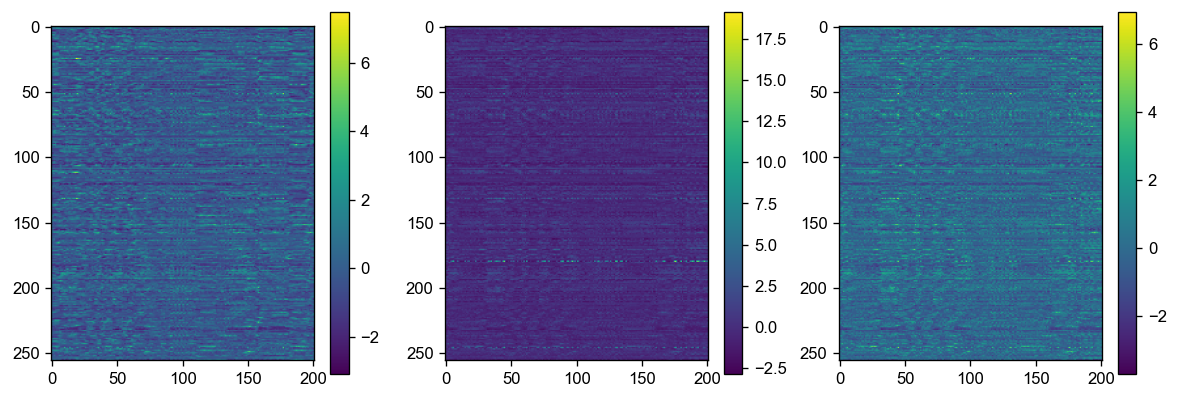

In [74]:
plt.figure(figsize=(12, 4), dpi=120)

plt.subplot(1,3,1)
plt.imshow(max_dist_fm[:, 0][0].cpu())
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(max_dist_fm[:, 1][0].cpu())
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(align_fm[0].cpu())
plt.colorbar()


In [9]:
org_emb   = x2embeddings(max_dist_fm[:, 0].cuda(), idx=2)
radio_emb = x2embeddings(max_dist_fm[:, 1].cuda(), idx=2)
alig_emb  = x2embeddings(align_fm.cuda(), idx=2)

NameError: name 'x2embeddings' is not defined

In [70]:
max_dist_fm[:, 0].shape

torch.Size([200, 256, 201])

In [69]:
org_emb.shape

torch.Size([200, 192])

In [8]:
torch.nn.functional.cosine_similarity(org_emb, radio_emb).mean(),
torch.nn.functional.cosine_similarity(org_emb, alig_emb).mean(),
torch.nn.functional.cosine_similarity(radio_emb, alig_emb).mean()

NameError: name 'org_emb' is not defined

In [65]:
def x2embeddings(x, idx=2):
    if idx == 0:
        fb_x = model.input_mask(x.cuda())
        if len(fb_x.shape) == 4:
            fb_x = fb_x.squeeze(1).float()
        fb_x = fb_x.transpose(1, 2)
        x1 = model.blocks[0](fb_x)
        x2 = model.blocks[1](x1)
        x3 = model.blocks[2](x2)
        x4 = model.blocks[3](x3)
    
    elif idx == 2:
        x2 = model.blocks[1](x)
        x3 = model.blocks[2](x2)
        x4 = model.blocks[3](x3)
    
    # xs.append(torch.stack([x1, x2, x3, x4,]))
    x5 = torch.cat([x2, x3, x4], dim=1)
    x6 = model.mfa(x5)
    x7 = model.asp(x6, lengths=None)
    x8 = model.asp_bn(x7)

    embeddings = model.fc(x8)
    return embeddings

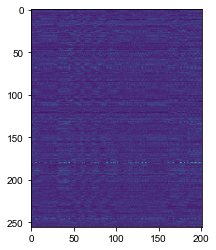

In [55]:
plt.imshow(align_fm[0].cpu())

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)


In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


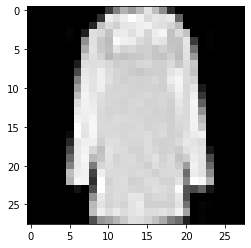

Label: 4


In [4]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
def inf_train_gen():
    while True:
        for images, targets in enumerate(dataloader):
            yield images, targets
gen = inf_train_gen
for it in range(num_iters):
    images, targets = gen.next()  

In [7]:
[h for h in range(1, 3-2)]

[]

In [49]:
dist_fn(source_sta.reshape(200, -1), align_sta.reshape(200, -1)).mean()

tensor(0.1135, device='cuda:4')

In [52]:
dist_fn(source_sta.reshape(200, -1), target_sta.reshape(200, -1)).mean()

tensor(0.1368, device='cuda:4')

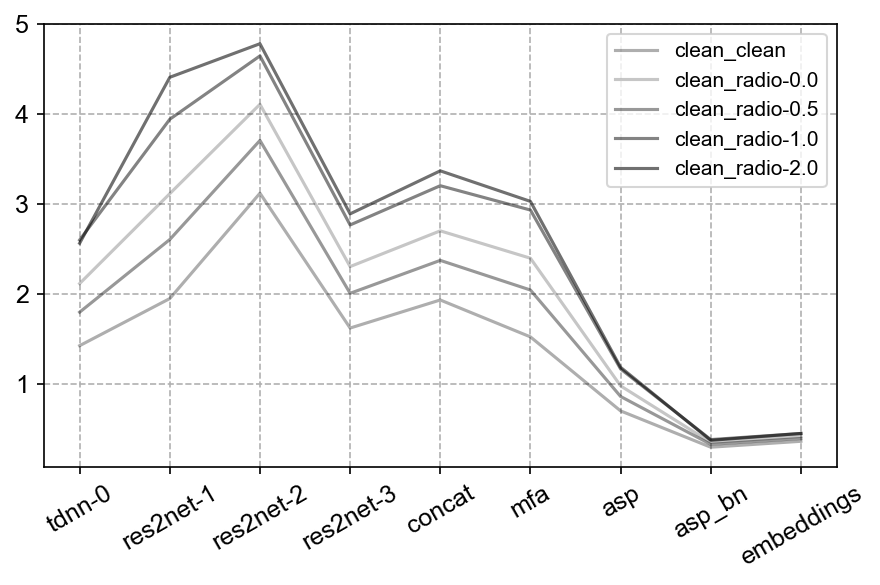

In [23]:
# save_name = 'imgs/model_chn256_mix/noise_level_x2.png'
# pdf = PdfPages('{}.pdf'.format(save_name))

ticks_font = 12
# plt.rcParams["font.family"] = "serif"
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

# plt.rcParams['font.serif'] = ['Times New Roman']  # 用来正常显示中文标签

# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams["font.family"] = "Arial"
# serif
plt.figure(figsize=(6,4), dpi=150)

#'tdnn-1', 
x = ['tdnn-0', 'res2net-1', 'res2net-2', 'res2net-3', 'concat', 'mfa', 'asp', 'asp_bn', 'embeddings',]

# p = 'imgs/model_chn256/dist.4.pickle'
# with open(p, 'rb') as f:
#         [dist_base, dist] = pickle.load(f)
        
# plt.plot(x, np.mean(dist_base, axis=0), marker='s')
# for i in range(5):
for i in [1, 0, 2, 3, 4]:
    plt.plot(x, (np.mean(dist, axis=0)[:, i] - np.mean(dist_base, axis=0))/np.mean(dist_base, axis=0), alpha=np.log((i+2)/8 + 1), c='black') #marker='o', 

# plt.ylim([0.001, 1])
# plt.yscale('log')
legs = ['clean_clean']
legs.extend(['clean_radio-{:.1f}'.format(s) for s in [0, 0.5, 1, 2, 5]])

plt.legend(legs)
_ = plt.xticks(fontsize=ticks_font, rotation=30)
_ = plt.yticks(fontsize=ticks_font)
plt.grid(linestyle='--')
plt.tight_layout()

# pdf.savefig()
# pdf.close()

# plt.savefig('imgs/model_chn256_mix/noise_level_x2.png')
# plt.savefig('imgs/model_chn256_inst/opt_shuffle_radios_clean_{}_dev{}_batch{}_stats_otherdata4_log_x1.png'.format(train_set, total_utts, batch_size))

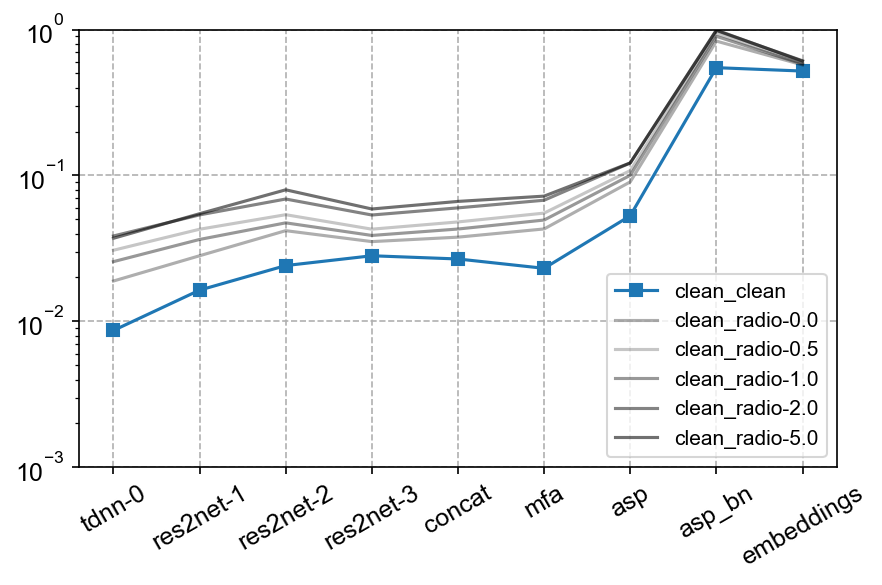

In [65]:
save_name = 'imgs/model_chn256_mix/noise_level_x2.png'
pdf = PdfPages('{}.pdf'.format(save_name))

ticks_font = 12
# plt.rcParams["font.family"] = "serif"
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

# plt.rcParams['font.serif'] = ['Times New Roman']  # 用来正常显示中文标签

# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams["font.family"] = "Arial"
# serif
plt.figure(figsize=(6,4), dpi=150)

#'tdnn-1', 
x = ['tdnn-0', 'res2net-1', 'res2net-2', 'res2net-3', 'concat', 'mfa', 'asp', 'asp_bn', 'embeddings',]

# p = 'imgs/model_chn256/dist.4.pickle'
# with open(p, 'rb') as f:
#         [dist_base, dist] = pickle.load(f)
        
plt.plot(x, np.mean(dist_base, axis=0), marker='s')
# for i in range(5):
for i in [1, 0, 2, 3, 4]:
    plt.plot(x, np.mean(dist, axis=0)[:, i], alpha=np.log((i+2)/8 + 1), c='black') #marker='o', 

plt.ylim([0.001, 1])
plt.yscale('log')
legs = ['clean_clean']
legs.extend(['clean_radio-{:.1f}'.format(s) for s in [0, 0.5, 1, 2, 5]])

plt.legend(legs)
_ = plt.xticks(fontsize=ticks_font, rotation=30)
_ = plt.yticks(fontsize=ticks_font)
plt.grid(linestyle='--')
plt.tight_layout()

pdf.savefig()
pdf.close()

# plt.savefig('imgs/model_chn256_mix/noise_level_x2.png')
# plt.savefig('imgs/model_chn256_inst/opt_shuffle_radios_clean_{}_dev{}_batch{}_stats_otherdata4_log_x1.png'.format(train_set, total_utts, batch_size))

### Noise Level

Using channel block in GNU Radio, we could set noise levels for simulated channels and obtain audio samples from these simulated channels. The noise level here is the deviation of gaussian noise in AWGN. The noise is added into the modulated radio signal. We test ECAPA-TDNN on VoxCeleb1 dataset from different channels with 5 types of noise level. The result is shown in Figure.\ref{}. 

As the noise level grows, the EER and MinDCF increase where the performance of model detorios. However, these audio samples has less changes listened by human ears.

As the noise level grows, the statistic shift between clean samples and radio samples increases. 

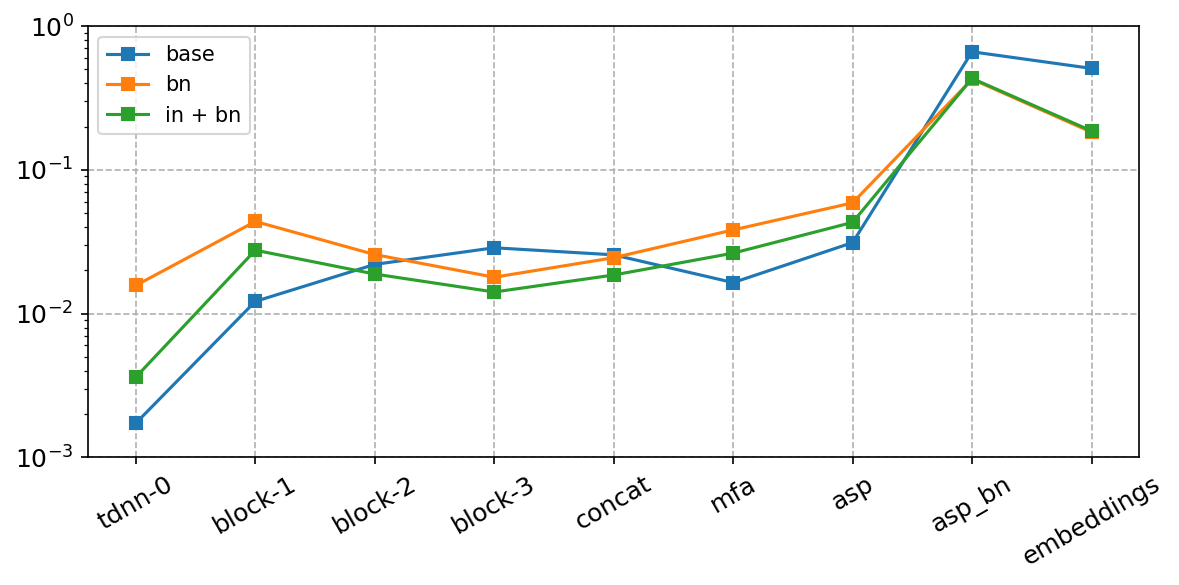

In [145]:
ticks_font = 12
plt.figure(figsize=(8,4), dpi=150)

#'tdnn-1', 
x = ['tdnn-0', 'block-1', 'block-2', 'block-3', 'concat', 'mfa', 'asp', 'asp_bn', 'embeddings',]

picks = ['imgs/mix_model_chn384/dist.pickle', 'imgs/inst_model_chn384/dist.pickle']

plt.plot(x, np.mean(dist_base, axis=0), marker='s')

for p in picks:
    with open(p, 'rb') as f:
        [dist_base, dist] = pickle.load(f)
        plt.plot(x, np.mean(dist, axis=0)[:, 1], marker='s')

plt.ylim([0.001, 1])
plt.yscale('log')

legs = ['base', 'bn', 'in + bn']
# legs.extend(['clean_radio{}'.format(s) for s in [0, 0.5, 2, 5]])

plt.legend(legs)
_=plt.xticks(fontsize=ticks_font, rotation=30)
_=plt.yticks(fontsize=ticks_font)
plt.grid(linestyle='--')
plt.tight_layout()

plt.savefig('imgs/models_opt_shuffle_radios_clean_{}_dev{}_batch{}_stats.png'.format(train_set, total_utts, batch_size))

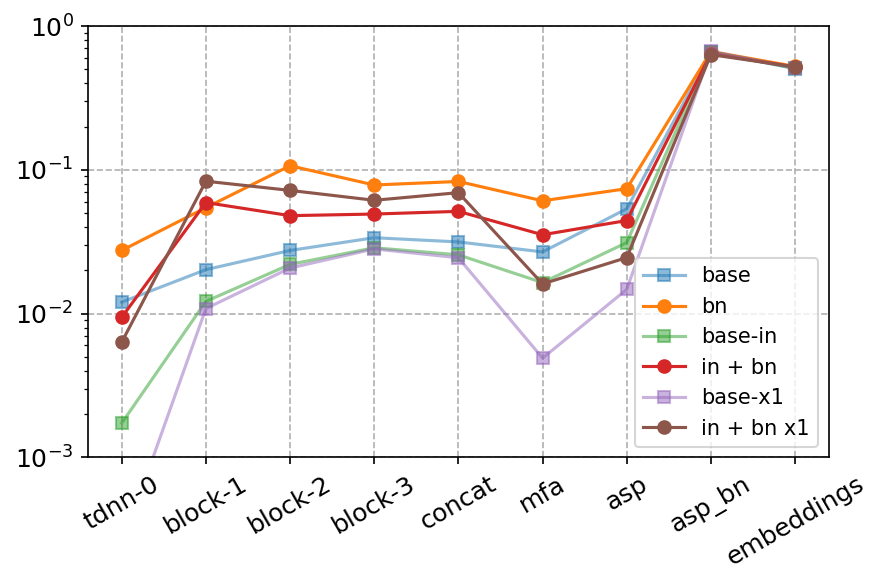

In [166]:
ticks_font = 12
plt.figure(figsize=(6,4), dpi=150)

#'tdnn-1', 
x = ['tdnn-0', 'block-1', 'block-2', 'block-3', 'concat', 'mfa', 'asp', 'asp_bn', 'embeddings',]

picks = ['imgs/model_chn256/dist.4.pickle', 'imgs/model_chn256_inst/dist.4.pickle', 'imgs/model_chn256_inst/dist.4.x1.pickle']


for p in picks:
    with open(p, 'rb') as f:
        [dist_base, dist] = pickle.load(f)
        plt.plot(x, np.mean(dist_base, axis=0), marker='s', alpha=0.5) #c='black'

        plt.plot(x, np.mean(dist, axis=0)[:, 1], marker='o')

plt.ylim([0.001, 1])
plt.yscale('log')
legs = ['base', 'bn', 'base-in', 'in + bn', 'base-x1', 'in + bn x1']
# legs.extend(['clean_radio{}'.format(s) for s in [0, 0.5, 2, 5]])

plt.legend(legs)
_=plt.xticks(fontsize=ticks_font, rotation=30)
_=plt.yticks(fontsize=ticks_font)
plt.grid(linestyle='--')
plt.tight_layout()

plt.savefig('imgs/models_opt_shuffle_radios_clean_{}_dev{}_batch{}_stats_log_x1.png'.format(train_set, total_utts, batch_size))

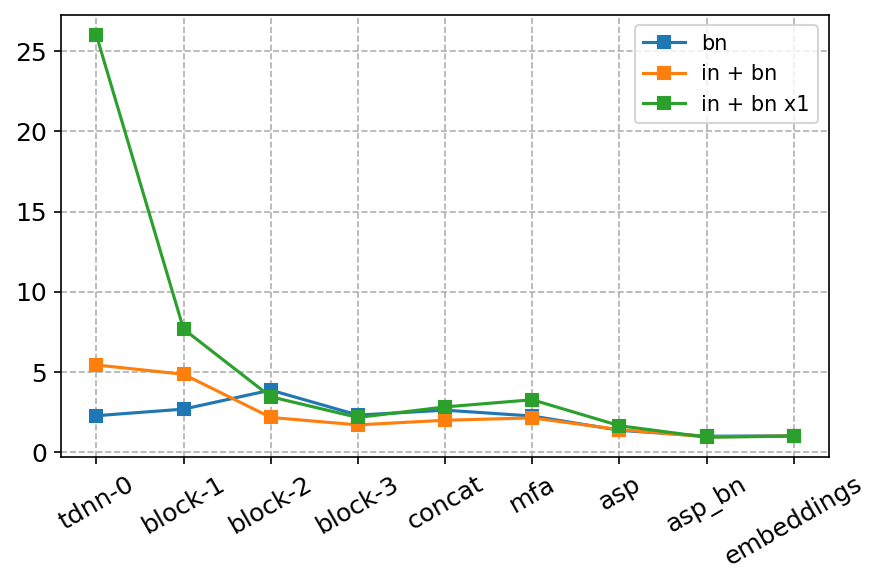

In [163]:
ticks_font = 12
plt.figure(figsize=(6,4), dpi=150)

#'tdnn-1', 
x = ['tdnn-0', 'block-1', 'block-2', 'block-3', 'concat', 'mfa', 'asp', 'asp_bn', 'embeddings',]

picks = ['imgs/model_chn256/dist.4.pickle', 'imgs/model_chn256_inst/dist.4.pickle', 'imgs/model_chn256_inst/dist.4.x1.pickle']


for p in picks:
    with open(p, 'rb') as f:
        [dist_base, dist] = pickle.load(f)
        # plt.plot(x, np.mean(dist_base, axis=0), marker='s', ) #c='black'

        plt.plot(x, np.mean(dist, axis=0)[:, 1] / np.mean(dist_base, axis=0), marker='s')

# plt.ylim([0.00, 1])
# plt.yscale('log')
legs = ['bn', 'in + bn', 'in + bn x1']
# legs.extend(['clean_radio{}'.format(s) for s in [0, 0.5, 2, 5]])

plt.legend(legs)
_=plt.xticks(fontsize=ticks_font, rotation=30)
_=plt.yticks(fontsize=ticks_font)
plt.grid(linestyle='--')
plt.tight_layout()

plt.savefig('imgs/models_opt_shuffle_radios_clean_{}_dev{}_batch{}_stats_subx1.png'.format(train_set, total_utts, batch_size))

### Feature divergence analysis

This paper aims to clarify the ineffectiveness in radio speaker verification of directly combining Instance Normalization Layers and Batch Normal Layers in previous studies \cite{}. To achieve this, we initiate our investigation by conducting a quantitative comparison. The focus is on pinpointing where disparities arise between data originating from distinct source domains during neural network computations. Our preliminary step is to identify and analyze these differences to shed light on the unsuccessful application of the combined Instance Normalization and BatchNorm Layers in prior research. 

In our research, we employ Wassertion distance for feature mapping comparison. 

### Conclusion

Using feature divergence analysis, we could find that how the statistic shift for the feature mappings of difference domains.

Adding instance normal layer into \['tdnn-0', 'block-1', 'block-2', 'block-3', 'mfa'\] may not be able to minimize the statistic shift caused by the data from other domain. The relative statistic shift increases for the feature mappings after \['tdnn-0', 'block-1'\] layers.



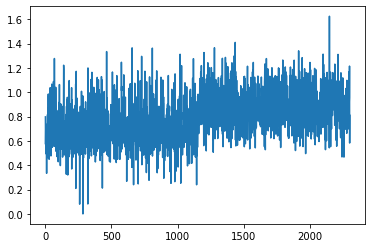

In [48]:
plt.plot(model.asp_bn.norm.weight.detach().cpu())

In [ ]:
torch.nn.init.ones_(self.weight)
torch.nn.init.zeros_(self.bias)

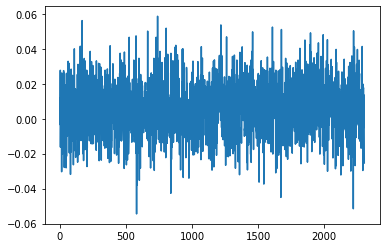

In [49]:
plt.plot(model.asp_bn.norm.bias.detach().cpu())

In [49]:
idx = np.arange(10)
np.random.shuffle(idx)

In [50]:
idx

array([2, 5, 7, 1, 4, 8, 6, 0, 9, 3])

In [158]:
inst = torch.nn.InstanceNorm1d(25)
bath = torch.nn.BatchNorm1d(25,affine=False)

In [159]:
x = torch.randn(12, 25)

In [157]:
inst(x).shape, bath(x).shape

(torch.Size([12, 25]), torch.Size([12, 25]))

In [161]:
inst(x) == bath(x)

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, 

In [47]:
x = torch.randn(384, 768)

In [48]:
inst = torch.nn.InstanceNorm1d(768, affine=False)
bn = torch.nn.BatchNorm1d(768, affine=False)

inst.train()
bn.train()

BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)

In [51]:
inst(x) - bn(x)

tensor([[ 0.0647,  0.2246,  0.0582,  ...,  0.0238,  0.0406,  0.0593],
        [ 0.0665,  0.0405,  0.0150,  ...,  0.0076,  0.0798,  0.0530],
        [-0.1153, -0.0009, -0.1283,  ..., -0.1484, -0.1353, -0.0301],
        ...,
        [ 0.0162, -0.1097, -0.0527,  ..., -0.0494, -0.0317, -0.0238],
        [ 0.0530,  0.0310,  0.0721,  ..., -0.0211,  0.0342,  0.0398],
        [-0.0613, -0.0584, -0.0040,  ..., -0.0814,  0.0453,  0.0079]])

In [173]:
cs = torch.nn.ChannelShuffle(2)

In [181]:
x = torch.randn(2, 12, 3)

In [187]:
x.reshape(2,2,6,3).transpose(1,2).reshape(2,12,3).reshape(2,6,2,3).transpose(1,2).reshape(2,12,3) == x

tensor([[[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]]])

In [188]:
torch.nn.functional.channel_shuffle(torch.nn.functional.channel_shuffle(x, 2), 6) == x

tensor([[[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True],
         [True, True, True]]])

In [51]:
x = torch.randn(12, 128, 300)

In [52]:
gn = torch.nn.GroupNorm(1, 128)

In [53]:
gn(x).shape

torch.Size([12, 128, 300])

In [57]:
for i in [1, 2, 4]:
    gn = torch.nn.GroupNorm(i, 128)
    print(gn.weight.shape, gn.bias.shape)

torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
torch.Size([128]) torch.Size([128])
